# Parameterizing Vertical Mixing Coefficients in the Ocean Surface Boundary Layer Using Neural Networks

### Group 2: Juan Palacios Godoy, Kefeng Shi, Yutong Wang, Sam Anwar

In this notebook, we expand upon the work from **Sane et al. (2023) "Parameterizing vertical mixing coefficients in the ocean surface boundary layer using neural networks." Journal of Advances in Modeling Earth Systems 15.10: [e2023MS003890](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2023MS003890)**. We extend the work in two ways:

1. Principal Component Analysis (PCA)
2. Sparse Gaussian Process Regression (GPR)

# 1. Setup workspace and Import packages

In [1]:
%%capture
import importlib

# Check and install torch
if importlib.util.find_spec("torch") is None:
    !pip install torch

# Check and install zarr
if importlib.util.find_spec("zarr") is None:
    !pip install zarr

# Ensure xarray is upgraded
!pip install --upgrade xarray

!pip install gpytorch
!pip install matplotlib

In [2]:
import time

start_time = time.time()

import os
import numpy as np
import matplotlib.pyplot as plt
import copy as copy
import matplotlib as mpl
import netCDF4 as ncd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from torch import nn, optim
import matplotlib.cm as cm
import copy as copy
import multiprocessing as mp
from scipy import stats
import time as time
import matplotlib.font_manager
import seaborn as sns
import pandas as pd
from tqdm import tqdm  # Import tqdm for the progress bar
import xarray as xr
import requests
import gpytorch

from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

today = datetime.today()
torch.cuda.empty_cache()

cwd=os.getcwd()
parent_dir = os.path.dirname(cwd)
os.chdir(parent_dir)
cwd = parent_dir
print("Current working directory:", os.getcwd())

# custom modules
import lib.func_file as ff_og
import lib.func_file_pca as ff_pca
from lib.visual_figure4 import performance_sigma_point
from lib.visual_figure3 import score_eval, save_losses_by_seed, plot_n1_scores
from lib.sparse_gpr_viz import *

np.random.seed(100)

cwd_data = cwd + '/data/'
## 
cwd_output = cwd + '/output/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Current working directory: /home/jovyan/climate-ml-project2-parametrization-group2/Group-2/Project2-Parameterization


# 2. Data 

In [3]:
# Open the dataset from Sane et al. 2023, here stored on the cloud, accessible on LEAP-Pangeo
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

# this function calculates the coriolis parameter from input latitude 
# 2*Omega*sin(lat), where Omega is the Earth's rotation in 1/s
def corio(lat):
    return  2*(2*np.pi/(24*60*60)) * np.sin(lat*(np.pi/180))

l0=corio(d['l'][:])
b00=d['b0'][:]
ustar0=d['ustar'][:]
h0=d['h'][:]
lat0=d['lat'][:]
heat0=d['heat'][:]
tx0=d['tx'][:] 
tx0=np.round(tx0,2)
SF0=d['SF'][:] 


## 2.1 Data Filtering
To ensure high-quality and valid data for training, specific filtering criteria are applied by Sane et al. (2023):

1. Heat flux ($ \text{heat} $) magnitude below 601 $ W/m^2 $.
2. Wind stress ($ \text{tx} $) below 1.2 $ N/m^2 $.
3. Boundary layer depth ($ \text{h} $) between 30 m and 300 m.

In [4]:
# Apply the constraints defined above
ind101=np.where(np.abs(heat0)<601)[0]
ind1=ind101 
ind2=np.where(tx0<1.2)[0]
ind3=np.where(h0>29)[0]
ind4=np.where(h0<301)[0]
# Filter the data to only those that obey the constraints
# ind7 is the final filter to indentify the data that will be input to N1 training
ind5=np.intersect1d(ind1,ind2)
ind6=np.intersect1d(ind3,ind5)
ind7=np.intersect1d(ind4,ind6) 

In [5]:
# there are 16 levels (1 at bottom, 16 at top)
mm1=0; mm2=16  #0; 16
# apply ind7 to keep only the profiles that meet the filtering criteria
# Training uses only 4 inputs: Coriolis parameter (l0), buoyancy flux (b00), surface friction velocity (ustar0) and boundary layer depth (h0)
data_load_main=np.zeros([len(h0[ind7]),4+mm2-mm1])
data_load_main[:,0]=l0[ind7]
data_load_main[:,1]=b00[ind7]
data_load_main[:,2]=ustar0[ind7]
data_load_main[:,3]=h0[ind7]
data_load_main[:,4:(mm2-mm1+4)]=SF0[ind7,mm1:mm2]

data_forc=np.zeros([len(ind7),3])
data_forc[:,0]=lat0[ind7]
data_forc[:,1]=heat0[ind7]
data_forc[:,2]=tx0[ind7]

data_load_pca=copy.deepcopy(data_load_main)
data_load_gpr=copy.deepcopy(data_load_main)

# 3. Principal Component Analysis (PCA)

## 3.1 Preprocessing

In our first extension in this project, we preprocess the training data by applying PCA with 10 components in order to reduce the model to retain the most influential information and streamline further analysis. PCA allows us reduce the dimensionality of the data while still capturing its variance. Our hypothesis was that this would add efficiency to our model.

In [6]:
__N_COMPONENTS__= 10
__DIM_RED_MODEL__ = 'PCA'
train_data_obj = ff_pca.preprocess_train_data_2(data_load_pca, 
                                                dimension_reduction_model=__DIM_RED_MODEL__,
                                                dimension_reduction_n_components=__N_COMPONENTS__) 

## 3.2 Validation Dataset

In this project, training and validation datasets are generated independently through separate simulations. This practice ensures **strict independence** between the two datasets, avoiding issues like **data leakage** or overfitting. 

Like our training dataset, the validation dataset is preprocessed with PCA (10 components).

In [7]:
url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
df = pd.read_csv(url, delim_whitespace=True, header = None)  
valid_data = df.iloc[:, 3:].values 

ind3=np.where(valid_data[:,3]>29)[0]
ind4=np.where(valid_data[:,3]<301)[0]
ind=np.intersect1d(ind3,ind4)

valid_data=np.concatenate((valid_data[ind,0:4],valid_data[ind,5:]), axis=1)

validation_data_obj = ff_pca.get_data_object(data=valid_data,
                                             dimension_reduction_model=__DIM_RED_MODEL__,
                                             dimension_reduction_n_components=__N_COMPONENTS__,
                                             mean_override=train_data_obj.transformed_mean,
                                             std_override=train_data_obj.transformed_std)


In [8]:
x=torch.FloatTensor(train_data_obj.exogenous_data()).to(device)
y=torch.FloatTensor(train_data_obj.endogenous_data()).to(device)

valid_x=torch.FloatTensor(validation_data_obj.exogenous_data()).to(device)
valid_y=torch.FloatTensor(validation_data_obj.endogenous_data()).to(device)

## 3.3 Neural Network Architecture

The learnKappa_layers class is a neural network model built using PyTorch's nn.Module. It consists of three fully connected (linear) layers with ReLU activation and dropout for regularization. 

Define here a 2 hidden-layer model

In [9]:
class learnKappa_layers(nn.Module):
    def __init__(self, In_nodes, Hid, Out_nodes):
        super(learnKappa_layers, self).__init__()
        self.linear1 = nn.Linear(In_nodes, Hid)  # First layer: Input to hidden
        self.linear2 = nn.Linear(Hid, Hid)       # Second layer: Hidden to hidden
        self.linear3 = nn.Linear(Hid, Out_nodes) # Third layer: Hidden to output
        self.dropout = nn.Dropout(0.25)          # Dropout for regularization

    def forward(self, x):
        x2 = self.linear1(x)
        h1 = torch.relu(x2)            # ReLU activation for layer 1
        h1 = self.dropout(h1)          # Apply dropout
        
        h2 = self.linear2(h1)
        h3 = torch.relu(h2)            # ReLU activation for layer 2
        h3 = self.dropout(h3)          # Apply dropout

        y_pred = self.linear3(h3)      # Final output layer
        return y_pred


## 3.4 Model Training post-PCA

In [10]:
# Weight for each layer. 
# ARRANGED FROM TOP (node = 16) TO BOTTOM (node = 1)
kmask=np.ones(__N_COMPONENTS__)
y_weights=torch.tensor(kmask).float().to(device)

In [11]:
# Train N1 for the first time!
epochs, k_points, lr=3000, __N_COMPONENTS__, 1e-03
in_nod, hid_nod, o_nod = 4, 64, __N_COMPONENTS__

torch.manual_seed(10)

model = learnKappa_layers(in_nod, hid_nod, o_nod)
model = model.to(device)
training_params = ff_pca.modeltrain_loss(lr=lr, epochs=epochs, x=x, y=y,
                                         valid_x=valid_x, valid_y=valid_y,
                                         model=model, y_weights=y_weights)

### in this version, there is no weighting in the loss function. This will be added in section 6. 

Training Progress:   1%|▏         | 38/3000 [00:25<32:45,  1.51epoch/s, patience_count=19, train_loss=0.596, valid_loss=0.776]


Early stopping at epoch 38. Validation loss has not improved for 20 epochs.


## 3.5 Evaluation and Visualization

### Training and validation loss over epochs

The model trained fairly quickly with fewer epochs. Training loss starts around 0.80 and drops to roughly 0.60 over 35 epochs. Validation loss is slightly lower than the training loss initially (around 0.78) and only decreases modestly over the same range, settling near 0.75. Loss values remain in the 0.60–0.80 range, indicating a relatively high loss scale.

The training loss curve shows a steady downward trend but over only 35 epochs. The validation loss also trends downward but more slowly, and the gap between training and validation remains fairly consistent. Because of the short training span, it’s unclear if the model would continue to improve significantly with more epochs.

Overall, PCA greatly reduced the training time, though the lowered dimensionality meant a higher loss.

### Discussion
* **Output of network:** Compared to the original analysis, there is significantly less variability, with the exception of nodes 10 - 12. This suggests more consistent predictive power.
* **Shape function:** In the original analysis, the shape function never exceeded 1.0. Under PCA, there is a far wider range of values, especially with nodes 8 - 12. Moreover, the right-side whiskers tend to be wider indicating high-value outliers.
* **Probability density histogram:** This model does not capture the bimodal distribution as well as the original analysis.
* **Error histogram:** The error distribution is more varied and less centered around zero.

Overall, the model was most effective in predicting the top layers (nodes 14 - 16).

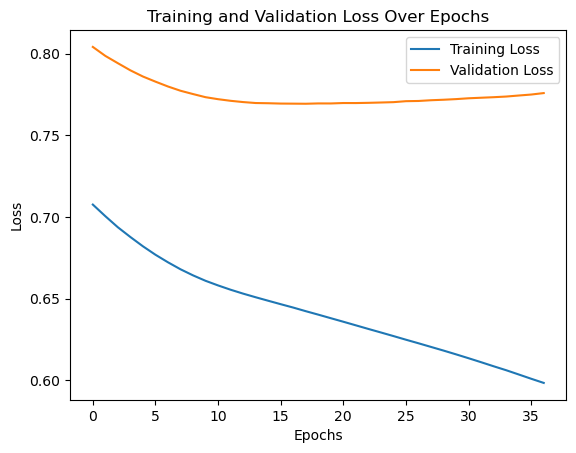

In [14]:

plt.plot(training_params.loss_array[:, 0], training_params.loss_array[:, 1], label="Training Loss")
plt.plot(training_params.loss_array[:, 0], training_params.loss_array[:, 2], label="Validation Loss")

# Adding labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()


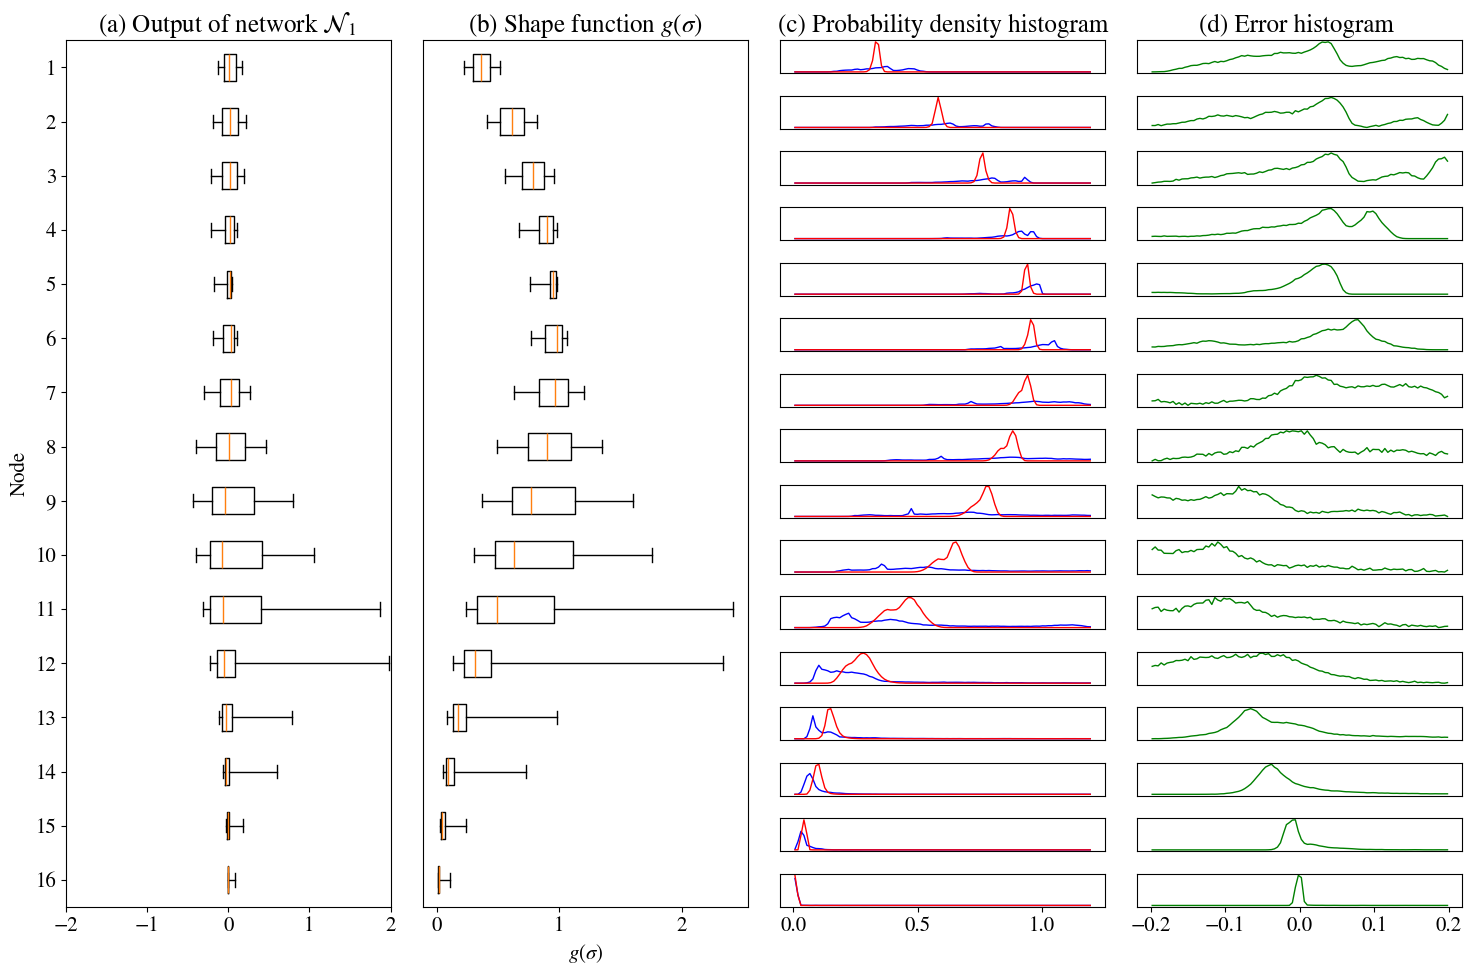

In [15]:
ff_pca.performance_sigma_point(
    model=training_params.model,
    x=x, 
    valid_x=valid_x,
    y=y,
    valid_y=valid_y,
    train_data_obj=train_data_obj)

# 4. Sparse Gaussian Process Regression (GPR)

The Sparse Gaussian Process Regression (SGPR) implemented in this notebook represents a sophisticated enhancement to the neural network model for vertical ocean diffusivity prediction. This approach combines the strengths of deep learning (neural networks) with Bayesian probabilistic modeling (Gaussian processes) to create a hybrid model that offers both improved accuracy and uncertainty quantification. The key innovation is using a Sparse Gaussian Process (SGP) on top of the neural network’s penultimate layer features. The sparsity is implemented through inducing points, which are a subset of training points that serve as a compact summary of the full dataset.

## 4.1 Preprocessing and validation dataset

This is the same as the original Sane et al. notebook, but differs slightly from the above PCA validation dataset so we reset it here.

In [17]:
data, x,y, stats, k_mean, k_std=ff_og.preprocess_train_data(data_load_gpr)  

In [18]:
# valid_data=np.loadtxt(cwd_data+'data_testing_4_paper.txt')[:,3:]

url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
df = pd.read_csv(url, delim_whitespace=True, header = None)  
valid_data = df.iloc[:, 3:].values 

ind3=np.where(valid_data[:,3]>29)[0]
ind4=np.where(valid_data[:,3]<301)[0]
ind=np.intersect1d(ind3,ind4)

valid_x=valid_data[ind,0:4]

valid_x[:,0]=(valid_x[:,0]-stats[0])/stats[1]
valid_x[:,1]=(valid_x[:,1]-stats[2])/stats[3]
valid_x[:,2]=(valid_x[:,2]-stats[4])/stats[5]
valid_x[:,3]=(valid_x[:,3]-stats[6])/stats[7]
k_mean_test=np.zeros(16)
valid_y=valid_data[ind,5:]

for i in range(len(valid_y)):
    valid_y[i,:]=np.log(valid_y[i,:]/np.max(valid_y[i,:]))

for i in range(16):
    valid_y[:,i]=(valid_y[:,i]-k_mean[i])/k_std[i]

x=torch.FloatTensor(x).to(device)
y=torch.FloatTensor(y).to(device)

valid_x=torch.FloatTensor(valid_x).to(device)
valid_y=torch.FloatTensor(valid_y).to(device)

## 4.2 Neural Network Architecture

In [20]:
class learnKappa_layers(nn.Module):
    def __init__(self, In_nodes, Hid, Out_nodes):
        super(learnKappa_layers, self).__init__()
        self.linear1 = nn.Linear(In_nodes, Hid)
        self.linear2 = nn.Linear(Hid, Hid)
        self.linear3 = nn.Linear(Hid, Out_nodes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x2 = self.linear1(x)
        h1 = torch.relu(x2)
        h1 = self.dropout(h1)

        h2 = self.linear2(h1)
        h3 = torch.relu(h2)
        h3 = self.dropout(h3)

        y_pred = self.linear3(h3)
        return y_pred

    def penultimate(self, x):
        """
        This method returns the hidden (penultimate) layer
        output before the final linear layer.
        """
        x2 = self.linear1(x)
        h1 = torch.relu(x2)
        h1 = self.dropout(h1)

        h2 = self.linear2(h1)
        h3 = torch.relu(h2)
        h3 = self.dropout(h3)

        # we do NOT apply the final linear3 here
        return h3


## 4.4 Base model training
The modeltrain_loss function trains a neural network model using PyTorch with a custom loss calculation and implements early stopping to prevent overfitting and save computing time.

Early Stopping: Stops training if the validation loss does not improve for patience consecutive epochs, saving the best model state. Increasing patience will further reduce loss, but lengthen runtime.

In [21]:
def modeltrain_loss(In_nodes, Hid, Out_nodes, lr, epochs, x, y, valid_x, valid_y, model, k_std_y, k_mean, k_std, patience=20):
    optimizer = torch.optim.Adam(model.parameters(), lr)  # Adam optimizer
    loss_fn = torch.nn.L1Loss(reduction='mean')  # L1 loss for gradient computation
    loss_array = torch.zeros([epochs, 3])  # Array to store epoch, train, and validation losses

    best_loss = float('inf')  # Initialize the best validation loss as infinity
    no_improvement = 0  # Counter for epochs without improvement
    best_model_state = None  # Placeholder for the best model state

    # Add a progress bar
    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as pbar:
        for k in range(epochs):
            optimizer.zero_grad()  # Clear gradients from the previous step
            y_pred = model(x)  # Forward pass for training data
            
            valid_pred = model(valid_x)  # Forward pass for validation data
            
            # Loss used for gradient calculation
            loss = loss_fn(y_pred * k_std_y, y * k_std_y)
            
            loss_train = torch.mean(torch.abs(torch.exp(y_pred * k_std + k_mean) - torch.exp(y * k_std + k_mean)))
            loss_valid = torch.mean(torch.abs(torch.exp(valid_pred * k_std + k_mean) - torch.exp(valid_y * k_std + k_mean)))
            
            loss.backward()  # Backpropagate the gradient
            optimizer.step()  # Update model parameters

            # Record the losses for this epoch
            loss_array[k, 0] = k  
            loss_array[k, 1] = loss_train.item()  
            loss_array[k, 2] = loss_valid.item()  

            # Update the progress bar with the current epoch and losses
            pbar.set_postfix(
                train_loss=loss_train.item(), 
                valid_loss=loss_valid.item(), 
                patience_count=no_improvement
            )
            pbar.update(1)  # Increment the progress bar

            # Early stopping: Check if validation loss improves
            if loss_valid.item() < best_loss:
                best_loss = loss_valid.item()  # Update best loss
                no_improvement = 0
                best_model_state = model.state_dict()  
            else:
                no_improvement += 1  # Increment no improvement counter

            # If no improvement for 'patience' epochs, stop training
            if no_improvement >= patience:
                print(f"\nEarly stopping at epoch {k+1}. Validation loss has not improved for {patience} epochs.")
                break

            # Free memory by deleting intermediate variables
            del loss, y_pred
            
    # Restore the best model state after training
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, loss_array[:k, :]


In [22]:
# Loss weighting option here, all weights = 1.0 in default run 
# Weight settings here
kms1=1.0 
kms2=1.0
# Weight per node set here. Set weights to kms1 or to kms2 to use values above
k16 = kms1; k15 = kms1; k14 = kms1; k13 = kms1; k12 = kms1; k11 = kms1; 
k10 = kms1; k9 = kms1; k8 = kms1; k7 = kms1; k6 = kms1; k5 = kms1; 
k4 = kms1; k3 = kms1; k2 = kms1; k1 = kms1; 
# Weight for each layer. 
# ARRANGED FROM TOP (node = 16) TO BOTTOM (node = 1)
kmask=np.array([k16,k15,k14,k13,k12,k11,k10,k9,k8,k7,k6,k5,k4,k3,k2,k1])

# Train N1 for the first time!
epochs, k_points, lr=3000, 16, 1e-03
in_nod, hid_nod, o_nod = 4, 32, 16

torch.manual_seed(10)

k_mean_c=torch.tensor(k_mean).float().to(device)
k_std_c=torch.tensor(k_std).float().to(device)

model = learnKappa_layers(in_nod, hid_nod, o_nod)
model = model.to(device)
model, loss_array = modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y,valid_x,valid_y,model,torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)

### in this version, there is no weighting in the loss function. This will be added in section 6. 

Training Progress:  20%|██        | 610/3000 [04:54<19:13,  2.07epoch/s, patience_count=19, train_loss=0.0398, valid_loss=0.0569]


Early stopping at epoch 610. Validation loss has not improved for 20 epochs.


## 4.5 Sparse GPR training

Each vertical level is treated as a separate regression problem, allowing the model to capture depth-dependent ocean processes. The data is converted to float tensors and moved to the device (GPU/CPU). A sparse approximation is used by selecting 200 random inducing points, striking a balance between accuracy and computational efficiency. Variational inference approximates the posterior by minimizing the ELBO with the Adam optimizer (learning rate 0.01) for 300 epochs, learning kernel hyperparameters, noise variance, and inducing point locations. A Cholesky-based variational distribution ensures numerical stability. The model uses a zero-mean function and a scaled RBF kernel (for smoothness), and a separate GP is trained for each depth level.

In [23]:
model = learnKappa_layers(in_nod, hid_nod, o_nod).to(device)

In [24]:
import gpytorch

model.eval()  # set NN to eval mode
with torch.no_grad():
    # penultimate features for the *training* set
    X_train_hid_torch = model.penultimate(x)  # shape [N, Hid]
    # Move them to CPU if needed
    X_train_hid_torch = X_train_hid_torch.cpu()
    
    # Suppose y is shape [N,16], i.e. we have 16 vertical levels
    Y_train_torch = y.cpu()  # shape [N,16]

In [25]:
class SparseGPRegressionModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## 4.6 Evaluation and visualization

In [ ]:
num_levels = 16
gp_models = []
likelihoods = []

for i in range(num_levels):
    print(f"Training GP for level {i} ...")
    
    # 1) Extract target for this level
    Y_train_level = Y_train_torch[:, i]  # shape [N]
    
    # 2) Convert to float if needed
    X_train_hid_torch = X_train_hid_torch.float()
    Y_train_level = Y_train_level.float()
    
    # 3) Move to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_train_hid_torch = X_train_hid_torch.to(device)
    Y_train_level = Y_train_level.to(device)
    
    # 4) Define the GP model and likelihood
    # e.g. pick M = 200 random inducing points for a sparse GP
    M = 200
    idx_inducing = np.random.choice(X_train_hid_torch.shape[0], M, replace=False)
    inducing_points = X_train_hid_torch[idx_inducing, :]
    
    model_gp = SparseGPRegressionModel(inducing_points).to(device)
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    
    # 5) Train using a Variational ELBO
    optimizer = torch.optim.Adam(
        list(model_gp.parameters()) + list(likelihood.parameters()),
        lr=0.01
    )
    mll = gpytorch.mlls.VariationalELBO(likelihood, model_gp, num_data=X_train_hid_torch.size(0))
    
    model_gp.train()
    likelihood.train()
    epochs_gp = 300
    
    for epoch in range(epochs_gp):
        optimizer.zero_grad()
        output = model_gp(X_train_hid_torch)
        loss = -mll(output, Y_train_level)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 50 == 0:
            print(f"  Level {i}, Epoch {epoch + 1}/{epochs_gp}, Loss = {loss.item():.3f}")
    
    # 6) Store the trained model and likelihood in lists
    gp_models.append(model_gp)
    likelihoods.append(likelihood)


### 4.6.1 Overall performance metrics comparison

This plot compares the overall performance metrics between your neural network (NN) and NN+GP models. The blue bars represent the error of the neural network alone, while the orange bars show the error after adding the Gaussian Process (GP) layer. The significant difference between the bars demonstrates that adding the GP layer substantially improves both mean absolute error (MAE) and root mean square error (RMSE). In this case, the GP enhancement has reduced MAE by approximately 60-65% and RMSE by about 50-55%, showing a dramatic improvement in prediction accuracy.

In [26]:
plot_error_by_level(results)

NameError: name 'results' is not defined

# 4. Gaussian Features

We seek to use neural networks (NNs) to predict these variable shape functions, building on the work of Sane et al. (2023)​. In particular, we implement two modeling strategies using PyTorch:
1. Direct shape prediction with Gaussian feature layer: Transform the input physical parameters through a Gaussian radial-basis function (RBF) layer, and have the network output the 16 discrete values of the shape function profile directly (at fixed vertical levels).
2. Gaussian Mixture Model (GMM) output: Have the network predict parameters of a Gaussian mixture (means, standard deviations, amplitudes), and reconstruct the shape function as a sum of Gaussians over the vertical coordinate.

Both models use the Coriolis parameter (l0), surface buoyancy flux (b0), friction velocity (ustar0), and boundary layer depth (h0) as inputs.

## 4.1 Data



In [18]:
# training dataset
ind101=np.where(np.abs(heat0)<601)[0]
ind1=ind101 
ind2=np.where(tx0<1.2)[0]
ind3=np.where(h0>29)[0]
ind4=np.where(h0<301)[0]
# Filter the data to only those that obey the constraints
# ind7 is the final filter to indentify the data that will be input to N1 training
ind5=np.intersect1d(ind1,ind2)
ind6=np.intersect1d(ind3,ind5)
ind7=np.intersect1d(ind4,ind6) 

# there are 16 levels (1 at bottom, 16 at top)
mm1=0; mm2=16  #0; 16
# apply ind7 to keep only the profiles that meet the filtering criteria
# Training uses only 4 inputs: Coriolis parameter (l0), buoyancy flux (b00), surface friction velocity (ustar0) and boundary layer depth (h0)
data_load_main=np.zeros([len(h0[ind7]),4+mm2-mm1])
data_load_main[:,0]=l0[ind7]
data_load_main[:,1]=b00[ind7]
data_load_main[:,2]=ustar0[ind7]
data_load_main[:,3]=h0[ind7]
data_load_main[:,4:(mm2-mm1+4)]=SF0[ind7,mm1:mm2]

data_forc=np.zeros([len(ind7),3])
data_forc[:,0]=lat0[ind7]
data_forc[:,1]=heat0[ind7]
data_forc[:,2]=tx0[ind7]

data_load3=copy.deepcopy(data_load_main)

print('started')

data, x,y, stats, k_mean, k_std=ff_og.preprocess_train_data(data_load3) 

# validation dataset

# valid_data=np.loadtxt(cwd_data+'data_testing_4_paper.txt')[:,3:]

url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
df = pd.read_csv(url, delim_whitespace=True, header = None)  
valid_data = df.iloc[:, 3:].values 

ind3=np.where(valid_data[:,3]>29)[0]
ind4=np.where(valid_data[:,3]<301)[0]
ind=np.intersect1d(ind3,ind4)

valid_x=valid_data[ind,0:4]

valid_x[:,0]=(valid_x[:,0]-stats[0])/stats[1]
valid_x[:,1]=(valid_x[:,1]-stats[2])/stats[3]
valid_x[:,2]=(valid_x[:,2]-stats[4])/stats[5]
valid_x[:,3]=(valid_x[:,3]-stats[6])/stats[7]
k_mean_test=np.zeros(16)
valid_y=valid_data[ind,5:]

for i in range(len(valid_y)):
    valid_y[i,:]=np.log(valid_y[i,:]/np.max(valid_y[i,:]))

for i in range(16):
    valid_y[:,i]=(valid_y[:,i]-k_mean[i])/k_std[i]

x=torch.FloatTensor(x).to(device)
y=torch.FloatTensor(y).to(device)

valid_x=torch.FloatTensor(valid_x).to(device)
valid_y=torch.FloatTensor(valid_y).to(device)

started


In [25]:
# Convert targets to log-space and normalize
y_log = np.log(y)              # log(g(sigma))
mean_log = y_log.mean(axis=0)        # mean for each of 16 levels
std_log  = y_log.std(axis=0)
y_norm = (y_log - mean_log) / std_log

# Standardize inputs (using training stats)
x_mean = x.mean(axis=0)
x_std  = x.std(axis=0)
x_norm = (x - x_mean) / x_std

# Normalization
valid_y_log = np.log(valid_y)
valid_y_norm = (valid_y_log - mean_log) / std_log

# Standardization
valid_x_norm = (valid_x - x_mean) / x_std

/tmp/ipykernel_4832/2196282203.py:2: RuntimeWarning: invalid value encountered in log
  y_log = np.log(y)              # log(g(sigma))
/tmp/ipykernel_4832/2196282203.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y_log = np.log(y)              # log(g(sigma))
/tmp/ipykernel_4832/2196282203.py:13: RuntimeWarning: invalid value encountered in log
  valid_y_log = np.log(valid_y)
/tmp/ipykernel_4832/2196282203.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  valid_y_log = np.log(valid_y)


In [26]:
class RBFShapeNet(nn.Module):
    def __init__(self, input_dim, num_centers, output_dim, centers, widths):
        super().__init__()
        # Register the RBF centers and widths as buffers (non-trainable tensors)
        self.register_buffer('centers', torch.tensor(centers, dtype=torch.float32))
        self.register_buffer('widths',  torch.tensor(widths, dtype=torch.float32))
        # Linear layer to map RBF features to 16 outputs (log(g) values)
        self.out_layer = nn.Linear(num_centers, output_dim)
    
    def forward(self, x):
        # x: shape (batch_size, input_dim), normalized inputs
        # Compute squared distance of x to each center (broadcasting)
        # centers: (num_centers, input_dim)
        diff = x.unsqueeze(1) - self.centers.unsqueeze(0)   # (batch, num_centers, input_dim)
        dist_sq = torch.sum(diff**2, dim=-1)                # (batch, num_centers)
        # Compute RBF activations: exp(-dist^2 / (2σ^2))
        phi = torch.exp(-dist_sq / (2 * (self.widths**2)))
        # Linear combination of RBF features to get outputs
        out = self.out_layer(phi)  # (batch, 16)
        return out

# Initialize RBF centers and widths (e.g., using 50 random training samples as centers)
num_centers = 50
idx = np.random.choice(len(x), num_centers, replace=False)
centers_init = x_norm[idx]                 # shape (50, 4)
widths_init = np.full(num_centers, 1.0)          # e.g. use width=1.0 for all, or tune as needed

# Instantiate the model
input_dim = x_norm.shape[1]   # 4
output_dim = y_norm.shape[1]  # 16
model_rbf = RBFShapeNet(input_dim, num_centers, output_dim, centers_init, widths_init)
print(model_rbf)

RBFShapeNet(
  (out_layer): Linear(in_features=50, out_features=16, bias=True)
)


/tmp/ipykernel_4832/370496203.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('centers', torch.tensor(centers, dtype=torch.float32))


In [27]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class GMMShapeNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_components):
        super().__init__()
        self.num_components = num_components
        # Two hidden layers (fully connected)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Output layer: predicts 3 * num_components parameters
        self.fc_out = nn.Linear(hidden_dim, 3 * num_components)
    
    def forward(self, x):
        # x: (batch_size, input_dim) normalized inputs
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        params = self.fc_out(h)  # shape (batch, 3*K)
        K = self.num_components
        mean_raw = params[:, 0:K]
        std_raw  = params[:, K:2*K]
        amp_raw  = params[:, 2*K:3*K]
        
        # Apply constraints
        means = torch.sigmoid(mean_raw)        # in (0,1)
        stds  = F.softplus(std_raw) + 1e-6      # >0
        amps  = F.softplus(amp_raw)             # >0
        
        # Sigma points as tensor (assumes global variable sigma_points exists)
        sigma = torch.tensor(sigma_points, dtype=torch.float32, device=x.device)
        
        # Compute Gaussians
        diff = sigma.unsqueeze(0).unsqueeze(0) - means.unsqueeze(2)  # (batch, K, 16)
        gauss = torch.exp(-0.5 * (diff / stds.unsqueeze(2)) ** 2)    # (batch, K, 16)
        weighted = amps.unsqueeze(2) * gauss                         # (batch, K, 16)
        g_sigma = torch.sum(weighted, dim=1)                         # (batch, 16)
        
        # Log and normalize
        log_g = torch.log(g_sigma + 1e-10)
        log_g_norm = (log_g - torch.tensor(mean_log, device=x.device)) / torch.tensor(std_log, device=x.device)
        return log_g_norm

model_gmm = GMMShapeNet(input_dim=4, hidden_dim=64, num_components=3)
print(model_gmm)

GMMShapeNet(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc_out): Linear(in_features=64, out_features=9, bias=True)
)


In [30]:
import torch.optim as optim
sigma_points = np.linspace(0, 1, 18)[1:-1]

def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=64, patience=10):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.L1Loss()  # L1 loss (MAE) on normalized log(g)
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_val_t   = torch.tensor(X_val, dtype=torch.float32)
    y_val_t   = torch.tensor(y_val, dtype=torch.float32)
    
    best_val_loss = float('inf')
    best_state = None
    patience_counter = 0
    
    for epoch in range(1, epochs+1):
        model.train()
        # Shuffle training data indices
        perm = torch.randperm(X_train_t.size(0))
        batch_losses = []
        for i in range(0, X_train_t.size(0), batch_size):
            idx = perm[i:i+batch_size]
            x_batch = X_train_t[idx]
            y_batch = y_train_t[idx]
            optimizer.zero_grad()
            output = model(x_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        # Compute average training loss for this epoch (optional)
        train_loss = np.mean(batch_losses)
        
        # Validation loss
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_t)
            val_loss = loss_fn(val_pred, y_val_t).item()
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()  # save best model parameters
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print progress
        if epoch % 10 == 0 or patience_counter == 0:
            print(f"Epoch {epoch}: Train loss={train_loss:.4f}, Val loss={val_loss:.4f}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch} (no improvement in {patience} epochs).")
            break
    
    # Load best model weights
    if best_state is not None:
        model.load_state_dict(best_state)
    return model


# Train the RBF model
model_rbf = train_model(model_rbf, x_norm, y_norm, valid_x_norm, valid_y_norm, epochs=100, patience=10)

/tmp/ipykernel_4832/2762710771.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_t = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipykernel_4832/2762710771.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_t = torch.tensor(y_train, dtype=torch.float32)
/tmp/ipykernel_4832/2762710771.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_t   = torch.tensor(X_val, dtype=torch.float32)
/tmp/ipykernel_4832/2762710771.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Epoch 10: Train loss=nan, Val loss=nan
Early stopping at epoch 10 (no improvement in 10 epochs).


In [31]:
# Train the GMM model
model_gmm = train_model(model_gmm, x_norm, y_norm, valid_x_norm, valid_y_norm, epochs=100, patience=10)

/tmp/ipykernel_4832/2762710771.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_t = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipykernel_4832/2762710771.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_t = torch.tensor(y_train, dtype=torch.float32)
/tmp/ipykernel_4832/2762710771.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_t   = torch.tensor(X_val, dtype=torch.float32)
/tmp/ipykernel_4832/2762710771.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

Epoch 10: Train loss=nan, Val loss=nan
Early stopping at epoch 10 (no improvement in 10 epochs).


# 6. Further Exploration

## 6.1 Modifying Loss Function with Node-Specific Weighting

As discussed at the end of section 3.4 of Sane et al. (2023), we adjust the training process by modifying the loss function to prioritize nodes with higher variance. Key steps and configurations:

**Node-Specific Weighting**: We applied node-specific weights (`kmask`) to amplify the loss values for nodes 8 to 13 by a factor of 100 (`kms2 = 100.0`), while keeping the weight at other nodes as 1.0 (`kms1 = 1.0`). 

This approach helps focus the model on reducing errors for nodes with higher variance, making them easier to learn.

In [25]:
# Loss weighting option here 
# Weight settings here
kms1=1.0 
kms2=100.0
idx=[3,4]
# Weight per node set here. Set weights to kms1 or to kms2 to use values above
k16 = kms1; k15 = kms1; k14 = kms1; k13 = kms2; k12 = kms2; k11 = kms2; 
k10 = kms2; k9 = kms2; k8 = kms2; k7 = kms1; k6 = kms1; k5 = kms1; 
k4 = kms1; k3 = kms1; k2 = kms1; k1 = kms1; 
# Weight for each layer. 
# ARRANGED FROM TOP (node = 16) TO BOTTOM (node = 1)
kmask=np.ones(__N_COMPONENTS__)
kmask[idx] = kms2
y_weights=torch.tensor(kmask).float().to(device)

In [26]:
epochs, k_points, lr=3000, __N_COMPONENTS__, 1e-03

# Loss weighting implemented here
in_nod, hid_nod, o_nod = 4, 16, __N_COMPONENTS__

torch.manual_seed(10)

model = learnKappa_layers(in_nod, hid_nod, o_nod)
model = model.to(device)
training_params = ff_pca.modeltrain_loss(lr=lr, 
                                         epochs=epochs, 
                                         x=x, 
                                         y=y,
                                         valid_x=valid_x,
                                         valid_y=valid_y,
                                         model=model,
                                         y_weights=y_weights)

Training Progress:   5%|▍         | 143/3000 [00:39<13:04,  3.64epoch/s, patience_count=19, train_loss=0.648, valid_loss=0.771]


Early stopping at epoch 143. Validation loss has not improved for 20 epochs.


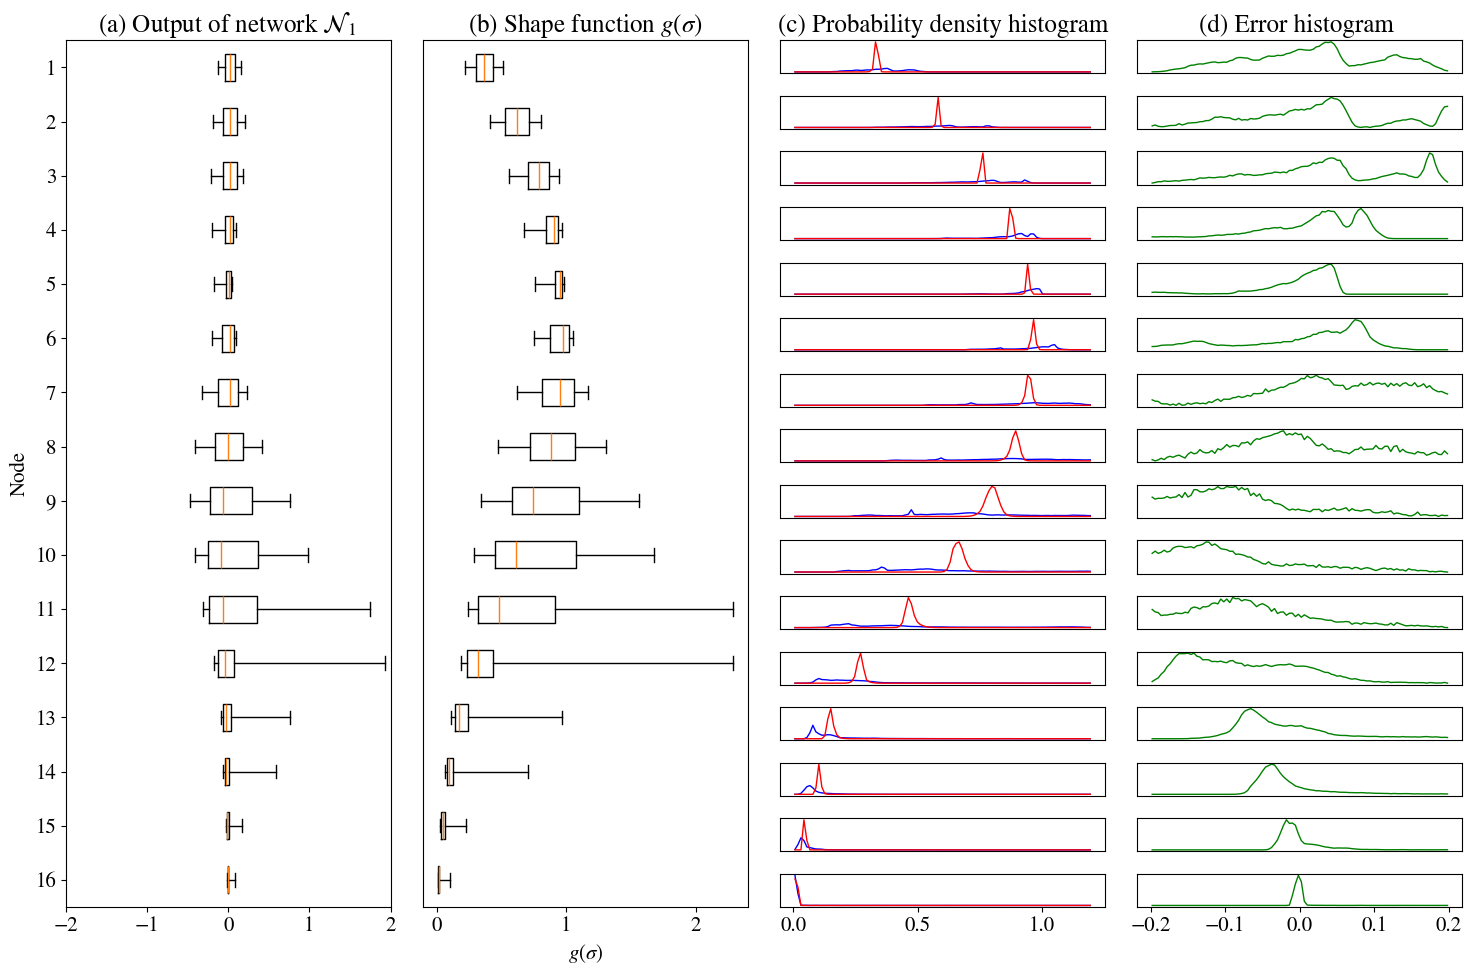

In [27]:
ff_pca.performance_sigma_point(
    model=training_params.model,
    x=x, 
    valid_x=valid_x,
    y=y,
    valid_y=valid_y,
    train_data_obj=train_data_obj)

## 6.2 Hyperparameter Sweep for Network Architecture

In this section, we conducted a hyperparameter sweep to evaluate the performance of different neural network architectures by varying:
- The **number of layers**.
- The **number of hidden nodes per layer**.

#### Parameter Count Calculation
The number of trainable parameters for a given architecture is calculated as:
$$
P = \sum_{l=1}^{L} \big( n_{\text{input}, l} \times n_{\text{output}, l} + n_{\text{output}, l} \big)
$$
Where:
- $ n_{\text{input}, l} $: Number of input nodes to layer $l $.
- $ n_{\text{output}, l} $: Number of output nodes from layer $ l$.

Using a **4-core CPU with 32GB RAM**, the estimated computational time for training all models with the above configurations is many hours. 

- **We recommend using a GPU server.**  

- In addition, limit sweep to **1-2 layers** and **2-64 hidden nodes** per layer. This enables a much faster, but still meaningful evaluation of the model's depth and width.


In [27]:
# Loss weighting option here, all weights = 1.0 in hyperparameter sweep
# Weight settings here
kms1=1.0 
kms2=1.0
# Weight per node set here. Set weights to kms1 or to kms2 to use values above
k16 = kms1; k15 = kms1; k14 = kms1; k13 = kms1; k12 = kms1; k11 = kms1; 
k10 = kms1; k9 = kms1; k8 = kms1; k7 = kms1; k6 = kms1; k5 = kms1; 
k4 = kms1; k3 = kms1; k2 = kms1; k1 = kms1; 
# Weight for each layer. 
# ARRANGED FROM TOP (node = 16) TO BOTTOM (node = 1)
kmask=np.array([k16,k15,k14,k13,k12,k11,k10,k9,k8,k7,k6,k5,k4,k3,k2,k1])

In [28]:
## We perform hyper-parameter sweep in this section.

epochs, k_points, lr=3000, __N_COMPONENTS__, 1e-03

hid_array=np.array([2,4,8,16,32,64])

lays = np.array([1,2])

torch.manual_seed(10)

first_print_done = False  # Ensure the success message prints only once

for la in lays:
    cwd_sd = cwd_output + 'ensemble_models_layers' + str(la) + '/'

    for h in hid_array:
        in_nod, hid_nod, o_nod = 4, h, 16
        print('la, h is >', la, h)

        if la == 1:
            model = ff.learnKappa_layers1(in_nod, hid_nod, o_nod)
        elif la == 2:
            model = ff.learnKappa_layers2(in_nod, hid_nod, o_nod)
        elif la == 3:
            model = ff.learnKappa_layers3(in_nod, hid_nod, o_nod)
        elif la == 4:
            model = ff.learnKappa_layers4(in_nod, hid_nod, o_nod)
        else:
            print('Check code')

        model = model.to(device)

        training_params = ff_pca.modeltrain_loss(lr=lr, 
                                     epochs=epochs, 
                                     x=x, 
                                     y=y,
                                     valid_x=valid_x,
                                     valid_y=valid_y,
                                     model=model,
                                     y_weights=y_weights)

        directory = os.path.join(cwd_sd, f'mod_dir_{h}')
        os.makedirs(directory, exist_ok=True)

        model_path = os.path.join(directory, 'model.pt')
        torch.save(model, model_path)

        loss_array = training_params.loss_array
        
        loss_path = os.path.join(directory, 'loss_array.txt')
        np.savetxt(loss_path, loss_array.detach().numpy())

        if not first_print_done:
            if os.path.exists(model_path):
                print(f"Model saved successfully: {model_path}")
            else:
                print(f"Failed to save model: {model_path}")

            if os.path.exists(loss_path):
                print(f"Loss array saved successfully: {loss_path}")
            else:
                print(f"Failed to save loss array: {loss_path}")

            first_print_done = True  

        del model, loss_array, training_params
        torch.cuda.empty_cache()

torch.cuda.empty_cache()


la, h is > 1 2


Training Progress:  43%|████▎     | 1291/3000 [00:19<00:25, 66.41epoch/s, patience_count=19, train_loss=0.0666, valid_loss=0.0921]



Early stopping at epoch 1291. Validation loss has not improved for 20 epochs.
Model saved successfully: /home/jovyan/Teaching/CPCsp2025/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers1/mod_dir_2/model.pt
Loss array saved successfully: /home/jovyan/Teaching/CPCsp2025/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers1/mod_dir_2/loss_array.txt
la, h is > 1 4


Training Progress:  28%|██▊       | 844/3000 [00:13<00:33, 64.45epoch/s, patience_count=19, train_loss=0.066, valid_loss=0.0858] 



Early stopping at epoch 844. Validation loss has not improved for 20 epochs.
la, h is > 1 8


Training Progress:  25%|██▌       | 755/3000 [00:12<00:36, 61.63epoch/s, patience_count=19, train_loss=0.0582, valid_loss=0.0807]



Early stopping at epoch 755. Validation loss has not improved for 20 epochs.
la, h is > 1 16


Training Progress:  46%|████▌     | 1368/3000 [00:25<00:30, 54.05epoch/s, patience_count=19, train_loss=0.0482, valid_loss=0.0687]



Early stopping at epoch 1368. Validation loss has not improved for 20 epochs.
la, h is > 1 32


Training Progress:  35%|███▌      | 1061/3000 [00:24<00:45, 42.71epoch/s, patience_count=19, train_loss=0.0455, valid_loss=0.0667]



Early stopping at epoch 1061. Validation loss has not improved for 20 epochs.
la, h is > 1 64


Training Progress:  47%|████▋     | 1399/3000 [00:47<00:54, 29.53epoch/s, patience_count=19, train_loss=0.0396, valid_loss=0.0597]



Early stopping at epoch 1399. Validation loss has not improved for 20 epochs.
la, h is > 2 2


Training Progress:  32%|███▏      | 948/3000 [00:16<00:34, 58.70epoch/s, patience_count=19, train_loss=0.075, valid_loss=0.0937] 



Early stopping at epoch 948. Validation loss has not improved for 20 epochs.
la, h is > 2 4


Training Progress:  27%|██▋       | 799/3000 [00:14<00:39, 56.28epoch/s, patience_count=19, train_loss=0.0719, valid_loss=0.0882]



Early stopping at epoch 799. Validation loss has not improved for 20 epochs.
la, h is > 2 8


Training Progress:  32%|███▏      | 947/3000 [00:18<00:39, 52.03epoch/s, patience_count=19, train_loss=0.055, valid_loss=0.0739] 



Early stopping at epoch 947. Validation loss has not improved for 20 epochs.
la, h is > 2 16


Training Progress:  35%|███▍      | 1043/3000 [00:25<00:46, 41.66epoch/s, patience_count=19, train_loss=0.0453, valid_loss=0.0626]



Early stopping at epoch 1043. Validation loss has not improved for 20 epochs.
la, h is > 2 32


Training Progress:  36%|███▋      | 1091/3000 [00:37<01:05, 28.99epoch/s, patience_count=19, train_loss=0.0363, valid_loss=0.0522]



Early stopping at epoch 1091. Validation loss has not improved for 20 epochs.
la, h is > 2 64


Training Progress:  42%|████▏     | 1265/3000 [01:11<01:38, 17.64epoch/s, patience_count=19, train_loss=0.0286, valid_loss=0.0428]



Early stopping at epoch 1265. Validation loss has not improved for 20 epochs.


In [29]:
## Uncertainty in training 4-32-32-16 model: 
## this is 4 input + 2 layers with 32 hidden nodes in each layer + 16 output nodes  
ensemble_dir = cwd_output + 'ensemble_models_layers2_uncertainty'
os.makedirs(ensemble_dir, exist_ok=True)

epochs, k_points, lr = 3000, __N_COMPONENTS__, 1e-03
in_nod, hid_nod, o_nod = 4, 32, __N_COMPONENTS__

seeds = np.arange(10, 15)

for seed in seeds:
    print(f"Training with seed {seed}")
    # Define model directory for this seed
    model_dir = os.path.join(ensemble_dir, f'mod_dir_{seed}')
    
    os.makedirs(model_dir, exist_ok=True)

    model = ff_pca.learnKappa_layers2(in_nod, hid_nod, o_nod)  # Update layers as needed
    model = model.to(device)

    # Train the model
    training_params = ff.modeltrain_loss(lr=lr, 
                                     epochs=epochs, 
                                     x=x, 
                                     y=y,
                                     valid_x=valid_x,
                                     valid_y=valid_y,
                                     model=model,
                                     y_weights=y_weights)

    # Save model and loss array for this seed
    torch.save(model, os.path.join(model_dir, 'model.pt'))
    np.savetxt(os.path.join(model_dir, 'loss_array.txt'), training_params.loss_array.detach().numpy())


Training with seed 10


Training Progress:  43%|████▎     | 1296/3000 [00:44<00:58, 28.96epoch/s, patience_count=19, train_loss=0.0351, valid_loss=0.0503]



Early stopping at epoch 1296. Validation loss has not improved for 20 epochs.
Training with seed 11


Training Progress:  28%|██▊       | 845/3000 [00:29<01:14, 29.09epoch/s, patience_count=19, train_loss=0.0375, valid_loss=0.0536]



Early stopping at epoch 845. Validation loss has not improved for 20 epochs.
Training with seed 12


Training Progress:  34%|███▎      | 1005/3000 [00:34<01:08, 29.06epoch/s, patience_count=19, train_loss=0.0379, valid_loss=0.0546]



Early stopping at epoch 1005. Validation loss has not improved for 20 epochs.
Training with seed 13


Training Progress:  22%|██▏       | 669/3000 [00:23<01:21, 28.51epoch/s, patience_count=19, train_loss=0.0395, valid_loss=0.0558]



Early stopping at epoch 669. Validation loss has not improved for 20 epochs.
Training with seed 14


Training Progress:  41%|████      | 1233/3000 [00:42<01:00, 29.21epoch/s, patience_count=19, train_loss=0.0364, valid_loss=0.0519]


Early stopping at epoch 1233. Validation loss has not improved for 20 epochs.


Scores saved successfully.
Losses saved by seed successfully.


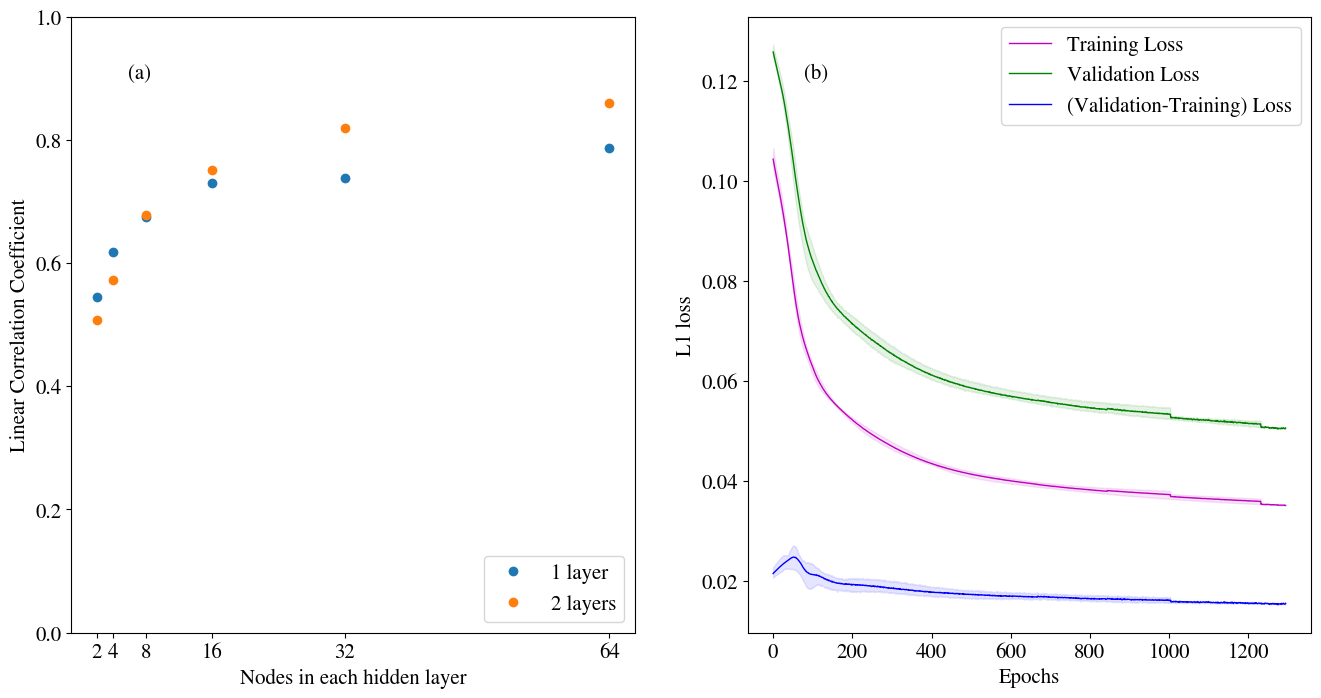

In [105]:
score_eval(hid_array, lays, valid_x, valid_y, k_mean_c, k_std_c, cwd_output)
save_losses_by_seed(os.path.join(cwd_output, 'ensemble_models_layers2_uncertainty/'), seeds)
plot_n1_scores(cwd_output, hid_array, lays, seeds, epochs=3000)

## Explanation and Discussion of Hyperparameter Sweep and Uncertainty Evaluation 
To identify the optimal hyperparameters for the model, we evaluate different configurations based on their **linear correlation coefficient** performance. The process is as follows:

- Hyperparameter Variation: We explore different numbers of hidden layers and nodes per layer. Each configuration is used to train the model, producing predictions for 16 $g(\sigma)$ points (denoted as $y$).

- Prediction Post-Processing: Each predicted $y$ is denormalized to restore its original scale. Extreme values (beyond the 5th-95th percentile) are removed to mitigate the influence of outliers, reduced the impact of noisy predictions. The Pearson correlation between the filtered predictions and the ground truth $y$ is computed.

- Final Correlation Computation: The mean correlation across all 16 $g(\sigma)$ points is taken as the final evaluation score for each hyperparameter set. This is plotted in (a). 

### Hyperparameter sweep, plot (a) 
Plot (a) shows that 2 layers with 64 nodes achieved the best performance under the linear correlation coefficient metric. 

**At 2 layers with 32 nodes, performance starts to asymptote. This is the structure selected in Sane et al. (2023) to balance skill and with computational cost.** 

Sane et al. (2023) Figure 3(a) shows a search up to 4 layers with 512 nodes. To reduce computational cost, we cut off the sweep at 2 layers with 64 nodes.

### L1 loss with uncertainty, plot (b)
Plot (b), for 2 layers with 32 nodes, we make an addition to Sane et al. (2023) by estimating uncertainty in model predictions by training with different random seeds. This captures variations in initialization. 

We use 5 random seeds to balance computational efficiency and result reliability. Increasing the number of seeds would provide a more robust estimation of uncertainty.